In [1]:
import os

import requests

from utils import to_b64, MODELS, get_model_controlnet, SAMPLERS, CONTROL_MODE

from PIL import Image
import numpy as np

import base64
import io

from datetime import datetime

from uuid import uuid4

import numpy

In [2]:
A111_url = "http://127.0.0.1:7860"

In [3]:
a = requests.get(A111_url + "/sdapi/v1/options")
a.json()

{'samples_save': True,
 'samples_format': 'png',
 'samples_filename_pattern': '',
 'save_images_add_number': True,
 'grid_save': True,
 'grid_format': 'png',
 'grid_extended_filename': False,
 'grid_only_if_multiple': True,
 'grid_prevent_empty_spots': False,
 'grid_zip_filename_pattern': '',
 'n_rows': -1.0,
 'font': '',
 'grid_text_active_color': '#000000',
 'grid_text_inactive_color': '#999999',
 'grid_background_color': '#ffffff',
 'enable_pnginfo': True,
 'save_txt': False,
 'save_images_before_face_restoration': False,
 'save_images_before_highres_fix': False,
 'save_images_before_color_correction': False,
 'save_mask': False,
 'save_mask_composite': False,
 'jpeg_quality': 80.0,
 'webp_lossless': False,
 'export_for_4chan': True,
 'img_downscale_threshold': 4.0,
 'target_side_length': 4000.0,
 'img_max_size_mp': 200.0,
 'use_original_name_batch': True,
 'use_upscaler_name_as_suffix': False,
 'save_selected_only': True,
 'save_init_img': False,
 'temp_dir': '',
 'clean_temp_dir_a

In [4]:
a = requests.get(A111_url + "/sdapi/v1/sd-vae")
a.json()

[{'model_name': 'difconsistencyRAWVAE_v10.pt',
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/VAE/difconsistencyRAWVAE_v10.pt'},
 {'model_name': 'klF8Anime2_klF8Anime2VAE.pt',
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/VAE/klF8Anime2_klF8Anime2VAE.pt'},
 {'model_name': 'vaeFtMse840000Ema_v100.pt',
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/VAE/vaeFtMse840000Ema_v100.pt'},
 {'model_name': 'color101VAE_v1.safetensors',
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/VAE/color101VAE_v1.safetensors'},
 {'model_name': 'toneRangeCompressor_trcvae.safetensors',
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/VAE/toneRangeCompressor_trcvae.safetensors'},
 {'model_name': 'anythingKlF8Anime2VaeFtMse840000_klF8Anime2.safetensors',
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/VAE/anythingKlF8Anime2VaeFtMse840000_klF8Anime2.safetensors'}]

In [11]:
def log_img(img, folder=None):
    if folder is not None:
        img.save(os.path.join(folder, datetime.now().strftime("%d%m_%H_%M%S") + f"{str(uuid4())[:5]}.png"))
        return
    img.save(os.path.join("log", datetime.now().strftime("%d%m_%H_%M%S") + ".png"))

In [18]:
def controlnet_generate(
        module_controlnet, model_controlnet, img, model, prompt, negative_prompt, sampler, steps,
        cfg_scale, denoising_strength, guidance_start, guidance_end, control_mode, x=64, y=64
):
    payload = {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "steps": steps,
        "batch_size": 10,
        "include_init_images": True,
        "init_images": [
            to_b64(img)
        ],
        "override_settings": {
            "sd_model_checkpoint": model,
            "sd_vae": "vaeFtMse840000Ema_v100.pt"
        },
        "width": img.shape[1],
        "height": img.shape[0],
        "sampler_index": sampler,
        "cfg_scale": cfg_scale,
        "denoising_strength": denoising_strength,
        
        "alwayson_scripts": {
            "controlnet": {
                "args": [
                    {
                        "input_image": to_b64(img),
                        "module": module_controlnet,
                        "model": model_controlnet,
                        "processor_res": max(img.shape),
                        "threshold_a": x,
                        "threshold_b": y,
                        "guidance_start": guidance_start,
                        "guidance_end": guidance_end,
                        "control_mode": CONTROL_MODE.index(control_mode),
                        "pixel_perfect": True
                    }
                ]
            }
        }
    }
    response = requests.post(f'{A111_url}/sdapi/v1/img2img', json=payload)
    out_path = os.path.join("log", model, prompt)
    os.makedirs(out_path, exist_ok=True)
    for i in response.json()["images"]:
        img = Image.open(io.BytesIO(base64.b64decode(i)))
        log_img(img, out_path)

In [19]:
SAMPLERS

['DPM++ 2M Karras',
 'DPM++ SDE Karras',
 'DPM++ 2M SDE Exponential',
 'DPM++ 2M SDE Karras',
 'Euler a',
 'Euler',
 'LMS',
 'Heun',
 'DPM2',
 'DPM2 a',
 'DPM++ 2S a',
 'DPM++ 2M',
 'DPM++ SDE',
 'DPM++ 2M SDE',
 'DPM++ 2M SDE Heun',
 'DPM++ 2M SDE Heun Karras',
 'DPM++ 2M SDE Heun Exponential',
 'DPM++ 3M SDE',
 'DPM++ 3M SDE Karras',
 'DPM++ 3M SDE Exponential',
 'DPM fast',
 'DPM adaptive',
 'LMS Karras',
 'DPM2 Karras',
 'DPM2 a Karras',
 'DPM++ 2S a Karras',
 'Restart',
 'DDIM',
 'PLMS',
 'UniPC']

In [23]:
IN_PATH = "/home/jjjj/Pictures/TEST_IMAGES_without"

for model_name in MODELS[5:]:
    print(model_name)
    for img in os.listdir(IN_PATH):
        img = numpy.array(Image.open(os.path.join(IN_PATH, img)))
        for j in [0.5, 1, 1.5]:
            print(j)
            controlnet_generate(
                "canny", get_model_controlnet("canny"), img, model_name, f"<lora:add_detail:{j}>", "", "DDIM",
                40, 7, 0.75, 0, 1, CONTROL_MODE[1], 100, 200
            )

deliberate_v3.safetensors [aadddd3d75]
0.5
1


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [15]:
CONTROL_MODE

['Balanced', 'My prompt is more important', 'ControlNet is more important']

In [ ]:
{
  "prompt": "white background, sugimori ken \\(style\\), pokemon \\(creature\\), full body, tornado creature with smoke tentacles and a menacing face solo, grin, happy, highres, no humans, other focus, pokemon, smile, solo, teeth, uneven eyes, ((masterpiece)) <lora:pokemon_v3_offset:1>",
  "negative_prompt": "(painting by bad-artist-anime:0.9), (painting by bad-artist:0.9), watermark, text, error, blurry, jpeg artifacts, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, artist name, (worst quality, low quality:1.4), bad anatomy",
  "cfg_scale": 7,
  "steps": 30,
  "sampler_index": "DPM++ SDE Karras",
  "seed": 479748350
}


In [11]:
import easyocr

In [12]:
eader = easyocr.Reader(['en'])


In [13]:
new_img = Image.open("/home/jjjj/Documents/gallery_view/log/cetusMix_Whalefall2.safetensors [876b4c7ba5]/<lora:add_detail:1>/1610_05_28438e691.png")
result = eader.readtext(np.array(new_img))


In [16]:
np.array(new_img).shape

(544, 408, 3)

In [5]:
def get_model_controlnet(name):
    a = requests.get(url=f'http://127.0.0.1:7860/controlnet/model_list').json()
    for i in a["model_list"]:
        if name in i:
            return i

In [6]:
get_model_controlnet("normal_map")

In [7]:
a = requests.get(url=f'http://127.0.0.1:7860/controlnet/model_list').json()
a

{'model_list': ['control_v11f1p_sd15_depth [cfd03158]',
  'control_v11p_sd15_canny [d14c016b]',
  'control_v11p_sd15_inpaint [ebff9138]',
  'control_v11p_sd15_lineart [43d4be0d]',
  'control_v11p_sd15_normalbae [316696f1]',
  'control_v11p_sd15_openpose [cab727d4]',
  'control_v11p_sd15_softedge [a8575a2a]',
  'control_v11p_sd15s2_lineart_anime [3825e83e]']}

In [8]:
a["model_list"]

['control_v11f1p_sd15_depth [cfd03158]',
 'control_v11p_sd15_canny [d14c016b]',
 'control_v11p_sd15_inpaint [ebff9138]',
 'control_v11p_sd15_lineart [43d4be0d]',
 'control_v11p_sd15_normalbae [316696f1]',
 'control_v11p_sd15_openpose [cab727d4]',
 'control_v11p_sd15_softedge [a8575a2a]',
 'control_v11p_sd15s2_lineart_anime [3825e83e]']

In [18]:
CONTROL_MODE = ["Balanced", "My prompt is more important", "ControlNet is more important"]


In [19]:
CONTROL_MODE.index("My prompt is more important")

1

In [8]:
get_model_controlnet("normal")

'control_v11p_sd15_normalbae [316696f1]'

In [5]:
requests.get(url=f'http://127.0.0.1:7860/controlnet/module_list').json()["module_list"]

['none',
 'canny',
 'depth',
 'depth_leres',
 'depth_leres++',
 'hed',
 'hed_safe',
 'mediapipe_face',
 'mlsd',
 'normal_map',
 'openpose',
 'openpose_hand',
 'openpose_face',
 'openpose_faceonly',
 'openpose_full',
 'dw_openpose_full',
 'clip_vision',
 'revision_clipvision',
 'revision_ignore_prompt',
 'ip-adapter_clip_sd15',
 'ip-adapter_clip_sdxl',
 'color',
 'pidinet',
 'pidinet_safe',
 'pidinet_sketch',
 'pidinet_scribble',
 'scribble_xdog',
 'scribble_hed',
 'segmentation',
 'threshold',
 'depth_zoe',
 'normal_bae',
 'oneformer_coco',
 'oneformer_ade20k',
 'lineart',
 'lineart_coarse',
 'lineart_anime',
 'lineart_standard',
 'shuffle',
 'tile_resample',
 'invert',
 'lineart_anime_denoise',
 'reference_only',
 'reference_adain',
 'reference_adain+attn',
 'inpaint',
 'inpaint_only',
 'inpaint_only+lama',
 'tile_colorfix',
 'tile_colorfix+sharp',
 'recolor_luminance',
 'recolor_intensity',
 'blur_gaussian']

In [3]:
a = requests.get(url=f'http://127.0.0.1:7860/controlnet/control_types').json()
a['control_types'].keys()

dict_keys(['All', 'Canny', 'Depth', 'NormalMap', 'OpenPose', 'MLSD', 'Lineart', 'SoftEdge', 'Scribble/Sketch', 'Segmentation', 'Shuffle', 'Tile/Blur', 'Inpaint', 'InstructP2P', 'Reference', 'Recolor', 'Revision', 'T2I-Adapter', 'IP-Adapter'])

In [4]:
a['control_types']['Reference']

{'module_list': ['none',
  'reference_adain',
  'reference_adain+attn',
  'reference_only'],
 'model_list': ['None',
  'control_v11e_sd15_shuffle [526bfdae]',
  'control_v11f1p_sd15_depth [cfd03158]',
  'control_v11p_sd15_canny [d14c016b]',
  'control_v11p_sd15_inpaint [ebff9138]',
  'control_v11p_sd15_lineart [43d4be0d]',
  'control_v11p_sd15_normalbae [316696f1]',
  'control_v11p_sd15_openpose [cab727d4]',
  'control_v11p_sd15_softedge [a8575a2a]',
  'control_v11p_sd15s2_lineart_anime [3825e83e]'],
 'default_option': 'reference_only',
 'default_model': 'None'}

In [8]:
get_model_controlnet("lineart_anime")

'control_v11p_sd15s2_lineart_anime [3825e83e]'

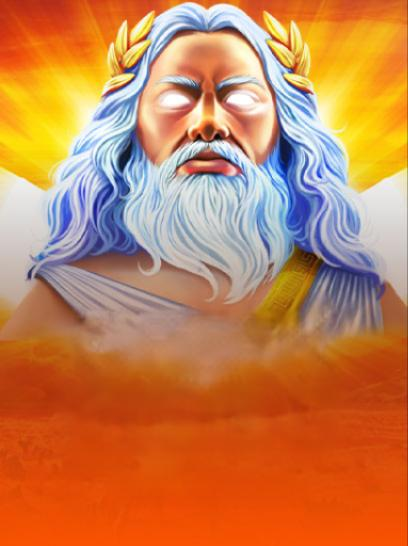

In [17]:
img = Image.open("/home/jjjj/Pictures/without/Greek Gods.jpg")
img

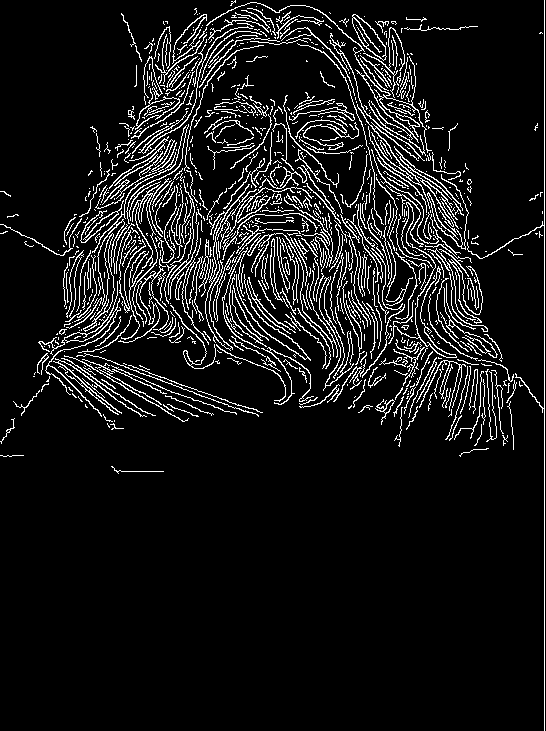

In [26]:
payload = {
    "controlnet_module": "canny",
    "controlnet_input_images": [to_b64(np.array(img))],
    "controlnet_processor_res": 546,
    "controlnet_threshold_a": 50,
    "controlnet_threshold_b": 100
}

a = requests.post(url=f'http://127.0.0.1:7860/controlnet/detect', json=payload).json()
Image.open(io.BytesIO(base64.b64decode(a["images"][0])))

In [22]:
a.keys()

dict_keys(['images', 'info'])

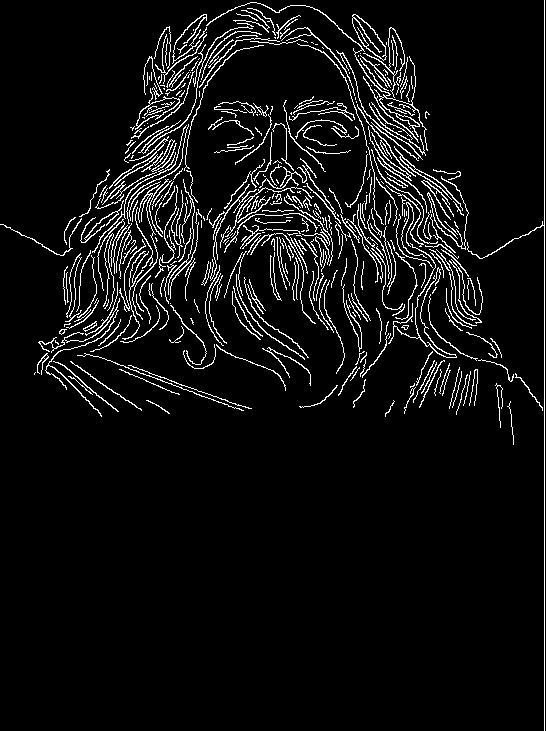

In [1]:
controlnet_module

In [13]:
import shutil
from glob import glob
import random
import os

In [14]:
IN_PATH = r"/home/jjjj/Documents/new"
OUT_PATH = r"/home/jjjj/Pictures/TEST_IMAGES"

In [15]:
for i in random.choices(os.listdir(IN_PATH), k=20):
    shutil.copy(IN_PATH + "/" + i, OUT_PATH + "/" + i)